SKT 대리점 입지 선정 분석

1. 필요 데이터 수집

    - 영등포구 지리데이터

    - 2019 09월 영등포 인구현황

    - 서울시 지하철역 정보

    - 서울시 버스 정류소 정보

    - 서울시 상권 정보 : 매출, 영역

    - SKT 공식 대리점 정보


2. 데이터 EDA

    - 기술 통계

    - 시각화


3. 입지 분석

    - 비지도학습(군집분석. K-Means, DBSCAN)

    - 지도학습(RandomForest)

* 필요 라이브러리 설치

In [1]:
!pip install geopandas
!pip install pygeos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.7 MB/s 
     |████████████████████████████████| 16.7 MB 22.3 MB/s 
     |████████████████████████████████| 6.3 MB 38.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 10.2 MB/s 


In [2]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import pyproj

import missingno as msno
import openpyxl
import math

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, silhouette_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings # 불필요한 경고문 삭제
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# 경로
DIR = '/content/drive/MyDrive/sph/'

# 파일 정보
filename = os.listdir(DIR)

# 1. 데이터 불러오기

In [4]:
# LSMD_CONT_LDREG_서울_영등포구.zip : http://data.nsdi.go.kr/dataset/20180220ds00001/resource/36a38d29-78dc-414b-94fa-ac63dbebc5fc
# 201909_201909_주민등록인구및세대현황_월간.csv
# 서울시 역사마스터 정보.csv
# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv
# 서울시버스정류소좌표데이터(2022.04.15).csv
# 서울시 우리마을가게 상권분석서비스(상권영역).csv

In [5]:
# 2019년 6월 SKT 영등포 50m단위 이용자 시간 데이터
df = pd.read_excel(DIR + 'sample_data.xlsx')

In [6]:
# 영등포구 지리데이터
gdf = gpd.GeoDataFrame.from_file(DIR + 'LSMD_CONT_LDREG_서울_영등포구.zip', encoding='euc-kr')

In [7]:
# 2019 영등포 인구현황
ingu = pd.read_csv(DIR + '201909_201909_주민등록인구및세대현황_월간.csv', encoding='euc-kr')

In [8]:
# 서울시 지하철 역사 정보
subway = pd.read_csv(DIR + '서울시 역사마스터 정보.csv', encoding='euc-kr')

In [9]:
# 서울시 버스 정류소 정보
bus = pd.read_csv(DIR + '서울시버스정류소좌표데이터(2022.04.15).csv', encoding='euc-kr')

In [10]:
# 서울시 상권 정보 - 매출
sales = pd.read_csv(DIR + '서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv', encoding='euc-kr')

In [11]:
# 서울시 상권 정보 - 영역
commerce = pd.read_csv(DIR + '서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='euc-kr')

# 2. 데이터 정보 확인

In [12]:
# SKT 데이터
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211426 entries, 0 to 211425
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 211426 non-null  int64  
 1   hour                 211426 non-null  int64  
 2   longitude            211426 non-null  float64
 3   latitude             211426 non-null  float64
 4   gu_code              211426 non-null  int64  
 5   gu_name              211426 non-null  object 
 6   dong_code            211426 non-null  int64  
 7   dong_name            211426 non-null  object 
 8   under10_ingu         211426 non-null  float64
 9   under20_ingu         211426 non-null  float64
 10  under30_ingu         211426 non-null  float64
 11  under40_ingu         211426 non-null  float64
 12  under50_ingu         211426 non-null  float64
 13  under60_ingu         211426 non-null  float64
 14  under70_ingu         211426 non-null  float64
 15  under80_ingu     

In [13]:
display(df.head(5), df.tail(5), df.sample(5))

date  hour   longitude   latitude  gu_code gu_name   dong_code  \
0  20190911     0  126.904651  37.510243    11560    영등포구  1156051500   
1  20190911     0  126.917051  37.516164    11560    영등포구  1156051500   
2  20190911     0  126.911425  37.512080    11560    영등포구  1156051500   
3  20190911     0  126.901812  37.511581    11560    영등포구  1156051500   
4  20190911     0  126.913667  37.514795    11560    영등포구  1156051500   

  dong_name  under10_ingu  under20_ingu  ...  upper80_male_ingu  \
0     영등포본동      0.477690      2.295678  ...           0.291999   
1     영등포본동      0.261749      2.162063  ...           0.387504   
2     영등포본동      0.003061      0.223033  ...           0.103522   
3     영등포본동      0.683299      4.209149  ...           0.359653   
4     영등포본동      0.218001      1.505187  ...           0.189097   

   under10_female_ingu  under20_female_ingu  under30_female_ingu  \
0             0.291928             0.916024             1.710428   
1             0.149363             0.938860             3.624611   
2             0.003061             0.133585             0.390273   
3             0.265973             1.946447             3.184111   
4             0.141304             0.692433             0.846153   

   under40_female_ingu  under50_female_ingu  under60_female_ingu  \
0             2.440412             3.262780             2.892460   
1             3.544734             2.772231             2.820026   
2             0.417927             0.513422             0.516027   
3             5.404459             4.894257             5.373596   
4             1.329714             1.272188             1.615956   

   under70_female_ingu  under80_female_ingu  upper80_female_ingu  
0             2.045463             1.043423             0.272596  
1             2.407307             1.139865             0.194348  
2             0.547065             0.373192             0.124435  
3             2.858021             1.359324             0.362667  
4             1.570745             0.773648             0.163622  

[5 rows x 35 columns]

date  hour   longitude   latitude  gu_code gu_name   dong_code  \
211421  20190911    23  126.895154  37.495322    11560    영등포구  1156072000   
211422  20190911    23  126.897993  37.493985    11560    영등포구  1156072000   
211423  20190911    23  126.897376  37.500291    11560    영등포구  1156072000   
211424  20190911    23  126.894519  37.503882    11560    영등포구  1156072000   
211425  20190911    23  126.899048  37.503454    11560    영등포구  1156072000   

       dong_name  under10_ingu  under20_ingu  ...  upper80_male_ingu  \
211421      대림3동      0.259839      0.821408  ...           0.338828   
211422      대림3동      0.244041      2.491240  ...           0.607740   
211423      대림3동      0.632651      3.588128  ...           0.456893   
211424      대림3동      0.166330      0.750364  ...           0.040895   
211425      대림3동      0.178583      1.028657  ...           0.113620   

        under10_female_ingu  under20_female_ingu  under30_female_ingu  \
211421             0.209732             0.214497             1.339766   
211422             0.173676             0.954278             3.209997   
211423             0.442157             1.789279             2.384821   
211424             0.099941             0.334251             0.643548   
211425             0.055669             0.575700             0.688038   

        under40_female_ingu  under50_female_ingu  under60_female_ingu  \
211421             1.715543             1.948409             1.884996   
211422             4.800293             7.806301             6.900917   
211423             2.956302             4.009075             4.793378   
211424             0.819663             1.041425             1.365142   
211425             0.975211             1.298103             1.332501   

        under70_female_ingu  under80_female_ingu  upper80_female_ingu  
211421             2.136364             1.290664             0.203570  
211422             5.651345             3.072848             0.923317  
211423             4.327258             1.651734             0.568758  
211424             1.141780             0.231236             0.110731  
211425             1.068511             0.594741             0.171656  

[5 rows x 35 columns]

date  hour   longitude   latitude  gu_code gu_name   dong_code  \
17698   20190911     2  126.905213  37.510696    11560    영등포구  1156051500   
141818  20190911    16  126.933462  37.515793    11560    영등포구  1156054000   
70900   20190911     8  126.909088  37.521532    11560    영등포구  1156053500   
140741  20190911    15  126.899664  37.497148    11560    영등포구  1156072000   
183990  20190911    20  126.913214  37.500371    11560    영등포구  1156069000   

       dong_name  under10_ingu  under20_ingu  ...  upper80_male_ingu  \
17698      영등포본동      0.365170      1.640264  ...           0.185080   
141818       여의동      0.000508      0.003071  ...           0.001188   
70900       영등포동      0.098483      0.154165  ...           0.050977   
140741      대림3동      0.213406      1.114208  ...           0.250843   
183990      신길7동      0.770890      2.870473  ...           0.265490   

        under10_female_ingu  under20_female_ingu  under30_female_ingu  \
17698              0.175759             0.657934             1.241800   
141818             0.000508             0.002218             0.007316   
70900              0.066225             0.074297             0.337296   
140741             0.138541             0.512568             0.827035   
183990             0.415814             1.241327             2.075724   

        under40_female_ingu  under50_female_ingu  under60_female_ingu  \
17698              1.822669             2.200613             2.194638   
141818             0.014260             0.011979             0.005433   
70900              0.412829             0.560869             0.611186   
140741             0.907290             1.890747             2.235261   
183990             4.234519             4.258503             3.713917   

        under70_female_ingu  under80_female_ingu  upper80_female_ingu  
17698              1.316597             0.771863             0.123287  
141818             0.002055             0.003732             0.000680  
70900              0.760612             0.453749             0.135263  
140741             2.137392             1.011791             0.133765  
183990             2.427166             2.018065             0.491568  

[5 rows x 35 columns]

In [14]:
df.describe()

date           hour      longitude       latitude   gu_code  \
count    211426.0  211426.000000  211426.000000  211426.000000  211426.0   
mean   20190911.0      11.511933     126.908673      37.520760   11560.0   
std           0.0       6.919037       0.015823       0.014318       0.0   
min    20190911.0       0.000000     126.878273      37.485439   11560.0   
25%    20190911.0       6.000000     126.896687      37.511520   11560.0   
50%    20190911.0      12.000000     126.906707      37.521555   11560.0   
75%    20190911.0      18.000000     126.919405      37.530913   11560.0   
max    20190911.0      23.000000     126.949853      37.555643   11560.0   

          dong_code   under10_ingu   under20_ingu   under30_ingu  \
count  2.114260e+05  211426.000000  211426.000000  211426.000000   
mean   1.156059e+09       0.228387       1.253968       3.204543   
std    6.024133e+03       0.339337       1.819190       5.565384   
min    1.156052e+09       0.000000       0.000000       0.000000   
25%    1.156054e+09       0.009036       0.079011       0.302090   
50%    1.156056e+09       0.115537       0.661187       1.604891   
75%    1.156062e+09       0.309218       1.687028       3.740847   
max    1.156072e+09       5.971869      30.339455     138.267928   

        under40_ingu  ...  upper80_male_ingu  under10_female_ingu  \
count  211426.000000  ...      211426.000000        211426.000000   
mean        4.775726  ...           0.181288             0.131913   
std         8.187178  ...           0.254748             0.202012   
min         0.000000  ...           0.000000             0.000000   
25%         0.485646  ...           0.009166             0.002638   
50%         2.448828  ...           0.106722             0.062470   
75%         5.649971  ...           0.251459             0.178894   
max       222.507677  ...           6.825863             3.836334   

       under20_female_ingu  under30_female_ingu  under40_female_ingu  \
count        211426.000000        211426.000000        211426.000000   
mean              0.604070             1.727053             2.209978   
std               0.903035             3.148774             3.714099   
min               0.000000             0.000000             0.000000   
25%               0.035644             0.147897             0.208485   
50%               0.310205             0.820556             1.144200   
75%               0.803419             1.960525             2.652754   
max              18.295030            82.540771            90.543966   

       under50_female_ingu  under60_female_ingu  under70_female_ingu  \
count        211426.000000        211426.000000        211426.000000   
mean              2.103090             1.832086             1.414956   
std               3.088622             2.483981             1.825269   
min               0.000000             0.000000             0.000000   
25%               0.188384             0.160412             0.113010   
50%               1.209982             1.137155             0.909676   
75%               2.689145             2.484599             1.966359   
max              60.862535            47.005390            57.673513   

       under80_female_ingu  upper80_female_ingu  
count        211426.000000        211426.000000  
mean              0.695179             0.204815  
std               0.929653             0.276714  
min               0.000000             0.000000  
25%               0.045846             0.011342  
50%               0.443922             0.123530  
75%               0.975287             0.285818  
max              51.395132             7.455296  

[8 rows x 33 columns]

In [15]:
# 영등포구 지리데이터
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37475 entries, 0 to 37474
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pnu         37475 non-null  object  
 1   jibun       37475 non-null  object  
 2   bchk        37475 non-null  object  
 3   sgg_oid     37475 non-null  int64   
 4   col_adm_se  37475 non-null  object  
 5   geometry    37475 non-null  geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 1.7+ MB


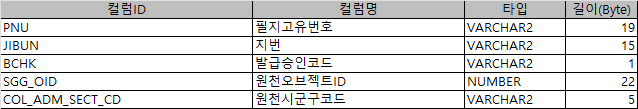

In [16]:
display(gdf.head(5), gdf.tail(5), gdf.sample(5))

pnu     jibun bchk  sgg_oid col_adm_se  \
0  1156013200103550075  355-75 잡    1   177215      11560   
1  1156013200108550001    855-1도    1   160499      11560   
2  1156013200103550076   355-76잡    1   161222      11560   
3  1156013200103550077  355-77 도    1   176705      11560   
4  1156013200103550176  355-176대    1   160161      11560   

                                            geometry  
0  POLYGON ((191354.906 444717.098, 191366.352 44...  
1  POLYGON ((193063.542 444828.676, 193073.269 44...  
2  POLYGON ((191380.050 444730.504, 191379.765 44...  
3  POLYGON ((191377.432 444726.832, 191376.445 44...  
4  POLYGON ((191306.476 444884.224, 191308.530 44...

pnu   jibun bchk  sgg_oid col_adm_se  \
37470  1156011400100320019  32-19대    1   142892      11560   
37471  1156011400100730009   73-9대    1   142894      11560   
37472  1156011400100390003   39-3대    1   142895      11560   
37473  1156011400100320061  32-61대    1   142896      11560   
37474  1156011400100320027  32-27대    1   142897      11560   

                                                geometry  
37470  POLYGON ((191108.068 447429.483, 191107.913 44...  
37471  POLYGON ((190859.664 447432.848, 190864.536 44...  
37472  POLYGON ((190886.269 447433.233, 190889.648 44...  
37473  POLYGON ((190974.371 447434.053, 190986.799 44...  
37474  POLYGON ((191072.747 447433.608, 191084.383 44...

pnu    jibun bchk  sgg_oid col_adm_se  \
34653  1156013300108420009   842-9대    1   171007      11560   
8483   1156010400100050044    5-44대    1   136519      11560   
412    1156013200104030042  403-42대    1   164061      11560   
13957  1156013300107030007   703-7대    1   171627      11560   
19520  1156010800100760004    76-4대    1   139271      11560   

                                                geometry  
34653  POLYGON ((191235.636 443573.954, 191235.348 44...  
8483   POLYGON ((191686.401 446340.814, 191685.992 44...  
412    POLYGON ((191326.427 444449.031, 191322.594 44...  
13957  POLYGON ((191018.080 443435.710, 191025.420 44...  
19520  POLYGON ((191579.628 446958.086, 191586.468 44...

In [17]:
# 영등포구 상권 정보 - 영역
commerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년월_코드    1671 non-null   int64  
 1   상권_구분_코드    1671 non-null   object 
 2   상권_구분_코드_명  1671 non-null   object 
 3   상권_코드       1671 non-null   int64  
 4   상권_코드_명     1671 non-null   object 
 5   엑스좌표_값      1671 non-null   int64  
 6   와이좌표_값      1671 non-null   int64  
 7   시군구_코드      1671 non-null   int64  
 8   행정동_코드      1671 non-null   int64  
 9   형태정보        0 non-null      float64
dtypes: float64(1), int64(6), object(3)
memory usage: 130.7+ KB


In [18]:
commerce.sample(5)

기준_년월_코드 상권_구분_코드 상권_구분_코드_명    상권_코드  상권_코드_명  엑스좌표_값  와이좌표_값  시군구_코드  \
179     202112        A       골목상권  2110412    창동중학교  204221  462436   11320   
705     202112        A       골목상권  2110813  보라매역 6번  192847  444735   11560   
1450    202112        R       전통시장  2130011     충신시장  200500  452753   11110   
1651    202112        R       전통시장  2130238   은행나무시장  192045  439138   11545   
1539    202112        R       전통시장  2130182     영천시장  196564  452315   11410   

        행정동_코드  형태정보  
179   11320690   NaN  
705   11560690   NaN  
1450  11110630   NaN  
1651  11545710   NaN  
1539  11410520   NaN

In [19]:
# 영등포구 인구 데이터
ingu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   행정구역              19 non-null     object 
 1   2019년09월_거주자 인구수  19 non-null     object 
 2   2019년09월_세대수      19 non-null     object 
 3   2019년09월_세대당 인구   19 non-null     float64
 4   2019년09월_남자 인구수   19 non-null     object 
 5   2019년09월_여자 인구수   19 non-null     object 
 6   2019년09월_남여 비율    19 non-null     float64
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [20]:
ingu.sample(5)

행정구역 2019년09월_거주자 인구수 2019년09월_세대수  \
9   서울특별시 영등포구 양평제2동(1156062000)           22,329        9,884   
15  서울특별시 영등포구 신길제7동(1156069000)           16,559        6,280   
11  서울특별시 영등포구 신길제3동(1156065000)           17,019        7,339   
12  서울특별시 영등포구 신길제4동(1156066000)            8,786        4,086   
16  서울특별시 영등포구 대림제1동(1156070000)           12,658        6,107   

    2019년09월_세대당 인구 2019년09월_남자 인구수 2019년09월_여자 인구수  2019년09월_남여 비율  
9              2.26          11,149          11,180            1.00  
15             2.64           8,268           8,291            1.00  
11             2.32           8,411           8,608            0.98  
12             2.15           4,392           4,394            1.00  
16             2.07           6,319           6,339            1.00

In [21]:
# 영등포구 지하철 역사 데이터
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   역사_ID   738 non-null    int64  
 1   역사명     738 non-null    object 
 2   호선      738 non-null    object 
 3   위도      738 non-null    float64
 4   경도      738 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 29.0+ KB


In [22]:
subway.sample(5)

역사_ID     역사명     호선          위도         경도
320   2545  군자(능동)    5호선  127.079577  37.557088
171   3129     신연수  인천1호선  126.693863  37.418040
474   1717      세마    경부선  127.043180  37.187533
233   2737      내방    7호선  126.993513  37.487618
349   2516      발산    5호선  126.837668  37.558598

In [23]:
# 서울시 버스 정류소 데이터
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11315 entries, 0 to 11314
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARS-ID  11315 non-null  int64  
 1   정류소명    11315 non-null  object 
 2   X좌표     11315 non-null  float64
 3   Y좌표     11315 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 353.7+ KB


In [24]:
bus.sample(5)

ARS-ID           정류소명         X좌표        Y좌표
1533     5175           광진구청  127.083153  37.538488
10802   24452  송파파인타운8단지.9단지  127.127473  37.478087
5118    13510           삼성빌라  126.933684  37.595690
3183     9227           솔샘터널  127.009004  37.618708
6647    16524          염창중학교  126.870934  37.553352

In [25]:
# 서울시 상권 정보 - 매출
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147972 entries, 0 to 147971
Data columns (total 80 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   기준_년_코드          147972 non-null  int64 
 1   기준_분기_코드         147972 non-null  int64 
 2   상권_구분_코드         147972 non-null  object
 3   상권_구분_코드_명       147972 non-null  object
 4   상권_코드            147972 non-null  int64 
 5   상권_코드_명          147972 non-null  object
 6   서비스_업종_코드        147972 non-null  object
 7   서비스_업종_코드_명      147972 non-null  object
 8   분기당_매출_금액        147972 non-null  int64 
 9   분기당_매출_건수        147972 non-null  int64 
 10  주중_매출_비율         147972 non-null  int64 
 11  주말_매출_비율         147972 non-null  int64 
 12  월요일_매출_비율        147972 non-null  int64 
 13  화요일_매출_비율        147972 non-null  int64 
 14  수요일_매출_비율        147972 non-null  int64 
 15  목요일_매출_비율        147972 non-null  int64 
 16  금요일_매출_비율        147972 non-null  int64 
 17  토요일_매출_비율 

In [26]:
sales.sample(5)

기준_년_코드  기준_분기_코드 상권_구분_코드 상권_구분_코드_명    상권_코드        상권_코드_명  \
3108       2019         1        A       골목상권  2110179        광나루역 1번   
74482      2019         3        A       골목상권  2110034       창신1동주민센터   
121029     2019         4        A       골목상권  2110509       연희대우아파트앞   
136150     2019         4        D       발달상권  2120107     공덕역(공덕오거리)   
145368     2019         4        R       전통시장  2130208  목동깨비시장(목3동시장)   

       서비스_업종_코드 서비스_업종_코드_명   분기당_매출_금액  분기당_매출_건수  ...  시간대_건수~24_매출_건수  \
3108    CS200007        치과의원   245204874       1721  ...               25   
74482   CS100001       한식음식점      689920         11  ...                0   
121029  CS300033         철물점     5790953        308  ...                0   
136150  CS300001        슈퍼마켓    83769835       9557  ...              465   
145368  CS100001       한식음식점  1805216843      75571  ...             7168   

        남성_매출_건수  여성_매출_건수  연령대_10_매출_건수  연령대_20_매출_건수  연령대_30_매출_건수  \
3108         945       776             0           325           234   
74482         11         0             0             0             0   
121029       149        88            15            66            67   
136150      6307      2884             0          1194          3419   
145368     37204     34960           252          8229         15442   

        연령대_40_매출_건수  연령대_50_매출_건수  연령대_60_이상_매출_건수  점포수  
3108             342           512              308    6  
74482              0            11                0    1  
121029            20            45               20    3  
136150          3168          1008              402   12  
145368         17835         18074            12332   90  

[5 rows x 80 columns]

# 3. 데이터 전처리

In [27]:
# 시간 데이터로 변경
df['date'] = df['date'].astype('str')
df['hour'] = df['hour'].astype('str')
df['date'] = pd.to_datetime(df['date'] + df['hour'], format='%Y%m%d%H')

In [28]:
# point 데이터로 변경
df['geom'] = gpd.points_from_xy(x=df['longitude'], y=df['latitude'])

### crs 좌표계 설정 및 컬럼 엔지니어링

In [29]:
df = gpd.GeoDataFrame(df, geometry='geom')
df = df.set_crs(4326)

In [30]:
gdf.crs = {'init':'epsg:5174'}
gdf = gdf.to_crs(4326)

In [31]:
# 인구 데이터 프레임 컬럼 엔지니어링
ingu = ingu.iloc[1:]
ingu['dong_name'] = ingu['행정구역'].apply(lambda x : x.split(' ')[2].split('(')[0].replace('제', ''))
ingu['dong_code'] = ingu['행정구역'].apply(lambda x : x.split(' ')[2][-11:-1])
ingu['2019년09월_거주자 인구수'] = ingu['2019년09월_거주자 인구수'].apply(lambda x : x.replace(',', '')).astype('int')
ingu = ingu[['dong_name', 'dong_code', '2019년09월_거주자 인구수']]
ingu['bin'] = pd.cut(ingu['2019년09월_거주자 인구수'], 5, labels=range(0,5)).astype('float')

In [32]:
# 지하철 데이터 프레임 컬럼 엔지니어링
subway['geom'] = gpd.points_from_xy(x=subway['위도'], y=subway['경도'])
subway = subway[['역사명', '역사_ID', 'geom']]
subway = gpd.GeoDataFrame(subway, geometry='geom')
subway = subway.set_crs(4326)

In [33]:
# 버스 데이터 프레임 컬럼 엔지니어링
bus['geom'] = gpd.points_from_xy(x=bus['X좌표'], y=bus['Y좌표'])
bus = bus[['ARS-ID', '정류소명', 'geom']]
bus = gpd.GeoDataFrame(bus, geometry='geom')
bus = bus.set_crs(4326)

In [34]:
# 상권 데이터 프레임 컬럼 엔지니어링
commerce['geom'] = gpd.points_from_xy(x=commerce['엑스좌표_값'], y=commerce['와이좌표_값'])
commerce = commerce[commerce['시군구_코드'] == 11560][['상권_코드', '행정동_코드', 'geom']]
commerce = gpd.GeoDataFrame(commerce, geometry='geom')
commerce = commerce.set_crs(5174)
commerce = commerce.to_crs(4326)

In [35]:
# 매출 데이터 프레임 컬럼 엔지니어링
sales = sales[(sales['기준_분기_코드'] == 3) & (
    sales['상권_코드'].isin(commerce['상권_코드'].unique()))][['상권_코드', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '분기당_매출_건수', '주중_매출_건수', '주말_매출_건수', '점포수']]

In [36]:
sales = pd.DataFrame(sales.groupby(by='상권_코드').sum())
sales.sort_index(inplace=True)

In [37]:
commerce.set_index('상권_코드', inplace=True)
commerce.sort_index(inplace=True)

In [38]:
# 상권 - 매출 데이터 프레임 join, 병합
comm_area = pd.concat([commerce, sales], axis=1)

In [39]:
comm_area[comm_area.점포수.isnull()]

행정동_코드                        geom  분기당_매출_금액  주중_매출_금액  주말_매출_금액  \
상권_코드                                                                          
2130239  11560610  POINT (126.89196 37.52560)        NaN       NaN       NaN   
2130251  11560535  POINT (126.90676 37.52263)        NaN       NaN       NaN   
2130259  11560630  POINT (126.91848 37.51381)        NaN       NaN       NaN   

         분기당_매출_건수  주중_매출_건수  주말_매출_건수  점포수  
상권_코드                                        
2130239        NaN       NaN       NaN  NaN  
2130251        NaN       NaN       NaN  NaN  
2130259        NaN       NaN       NaN  NaN

In [40]:
# 'null'제거
comm_area = comm_area.dropna(axis=0)

In [41]:
# '동' 정보 카테고리 타입으로 변경
df[['dong_code', 'dong_name']] = df[['dong_code', 'dong_name']].astype('category')

In [42]:
# 전 연령 인구 총합 컬럼 추가
df['all_ingu'] = df.filter(like='0_ingu').sum(axis=1)

In [43]:
# 전체 여성 인구 총합 컬럼 추가
df['all_female_ingu'] = df.filter(like='0_female_ingu').sum(axis=1)

In [44]:
# 전체 남성 인구 총합 컬럼 추가
df['all_male_ingu'] = df.filter(like='0_male_ingu').sum(axis=1)

In [45]:
# 연령대 컬럼 추가
df['1020_ingu'] = df['under10_ingu'] + df['under20_ingu']
df['3040_ingu'] = df['under30_ingu'] + df['under40_ingu']
df['5060_ingu'] = df['under50_ingu'] + df['under60_ingu']
df['7080_ingu'] = df['under70_ingu'] + df['under80_ingu'] + df['upper80_ingu']

In [46]:
df = df[['date', 'dong_code', 'dong_name', 'geom', 'all_ingu', 'all_female_ingu', 'all_male_ingu',
         '1020_ingu', '3040_ingu', '5060_ingu', '7080_ingu']]

In [47]:
# 좌표계 확인
print(df.crs)
print(gdf.crs)
print(bus.crs)
print(subway.crs)
print(comm_area.crs)

epsg:4326
epsg:4326
epsg:4326
epsg:4326
epsg:4326


### 간단한 데이터 확인

In [48]:
# 시간별, 동별 유동인구 수 상위 20개
display(df[df['date'].dt.hour.between(9, 21)].groupby(by=[df.date.dt.hour, 'dong_name']).sum().sort_values(['all_ingu'], ascending=False).sum(axis=1).head(20))

date  dong_name
10    여의동          239327.940282
11    여의동          238766.070690
12    여의동          233934.122045
9     여의동          232464.324044
13    여의동          227453.266299
14    여의동          216425.082667
15    여의동          200482.996227
16    여의동          178489.907342
17    여의동          150096.764938
18    여의동          122664.298891
19    여의동          108354.876114
20    여의동           99887.759007
15    영등포동          98660.445014
16    영등포동          97596.259491
17    영등포동          96969.192512
14    영등포동          96196.801680
13    영등포동          93784.097325
12    영등포동          91802.252136
18    영등포동          91258.562038
21    여의동           88932.169235
dtype: float64

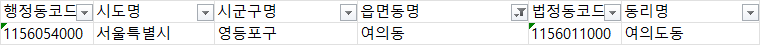

In [49]:
# 여의도동의 행정동코드에 해당되는 데이터
gdf[gdf['pnu'].str.startswith(pat='1156011000')]

pnu   jibun bchk  sgg_oid col_adm_se  \
2220   1156011000100350004   35-4대    1   140573      11560   
2245   1156011000100830006   83-6천    1   140285      11560   
2246   1156011000100870004   87-4천    1   140286      11560   
2247   1156011000100080000      8제    1   140287      11560   
2248   1156011000100810012  81-12도    1   140290      11560   
...                    ...     ...  ...      ...        ...   
34298  1156011000100070020   7-20도    1   140719      11560   
34299  1156011000100070019   7-19도    1   140720      11560   
34300  1156011000100070018   7-18도    1   140721      11560   
34301  1156011000100480003   48-3대    1   140722      11560   
34995  1156011000100620000    62 대    1   175153      11560   

                                                geometry  
2220   POLYGON ((126.92602 37.52163, 126.92627 37.521...  
2245   POLYGON ((126.92159 37.53417, 126.92159 37.534...  
2246   POLYGON ((126.94422 37.53419, 126.94422 37.534...  
2247   POLYGON ((126.91260 37.53390, 126.91290 37.533...  
2248   POLYGON ((126.91028 37.53297, 126.91035 37.532...  
...                                                  ...  
34298  POLYGON ((126.93455 37.51751, 126.93478 37.517...  
34299  POLYGON ((126.93432 37.51749, 126.93436 37.517...  
34300  POLYGON ((126.93425 37.51743, 126.93378 37.517...  
34301  POLYGON ((126.92794 37.51744, 126.92806 37.517...  
34995  POLYGON ((126.93760 37.51810, 126.93770 37.517...  

[526 rows x 6 columns]

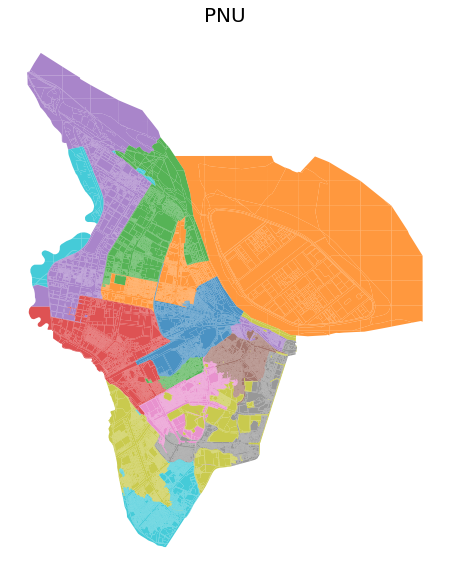

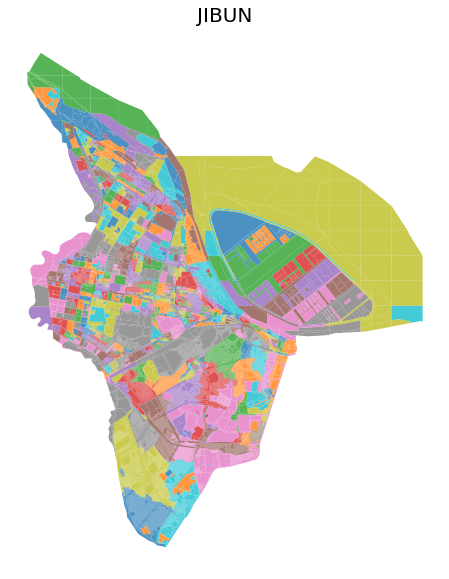

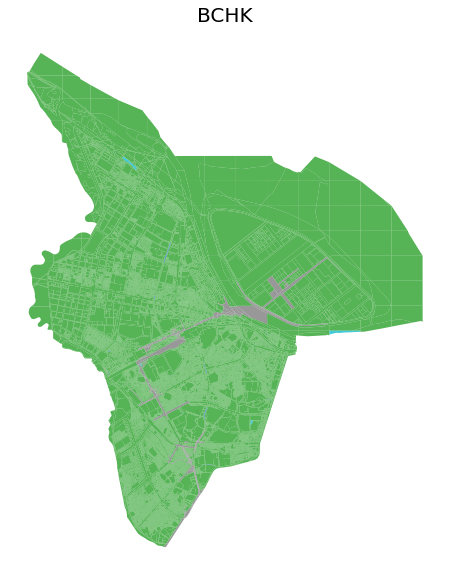

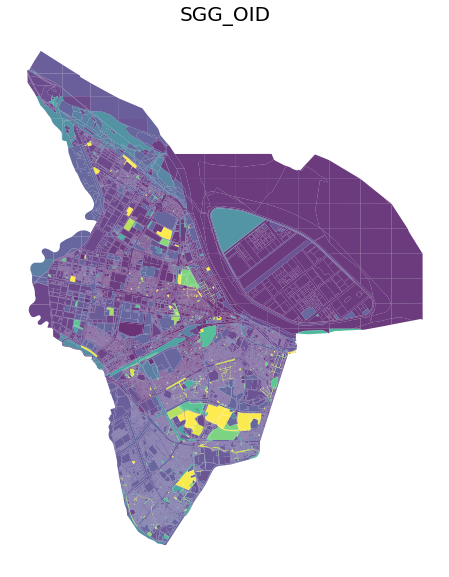

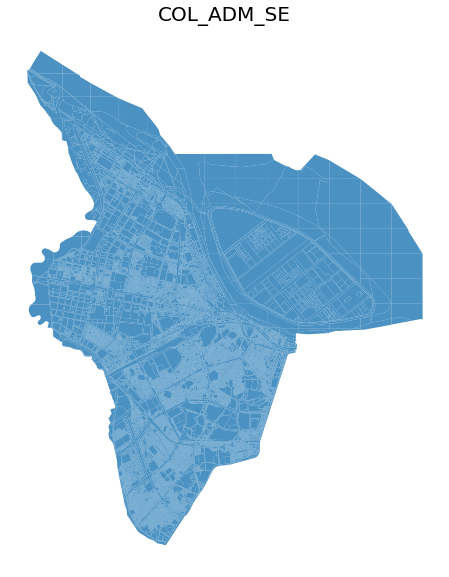

In [50]:
# 영등포 지리 데이터 프레임 시각화
for col in ['pnu', 'jibun', 'bchk', 'sgg_oid', 'col_adm_se']:
    ax = gdf.plot(column=col, figsize=(10,10), alpha=0.8)
    ax.set_title(col.upper(), fontsize=20)
    ax.set_axis_off()
    plt.show()

# 4. 컬럼 엔지니어링

* 비즈니스 타임 : 오전 9시부터 오후 9시까지를 사람들이 주로 활동하는 시간으로 적용하였다.

In [51]:
# all 24시간
grouped_all = pd.DataFrame(df.groupby(by=[df['geom'].astype('str'), 'dong_name'], as_index=True)['all_ingu'].sum()).reset_index()
grouped_all = grouped_all[grouped_all['all_ingu'] > 0.0].reset_index(drop=True).set_index('geom')

# business 비즈니스 타임
grouped_bsn = pd.DataFrame(df.loc[df['date'].dt.hour.between(9, 21)].groupby(by=[df['geom'].astype('str'), 'dong_name'], as_index=True)['all_ingu'].sum()).reset_index()
grouped_bsn = grouped_bsn[grouped_bsn['all_ingu'] > 0.0].reset_index(drop=True).set_index('geom')

### SKT 대리점 데이터

* 출처 : SKT 공식 홈페이지, Google Map

In [52]:
skt = pd.DataFrame([[37.5193677, 126.9327683, '여의동'],
[37.5250383, 126.925542, '여의동'],
[37.5350961, 126.8999555, '당산2동'],
[37.5222919, 126.8939204, '당산1동'],
[37.5149613, 126.8873048, '문래동'],
[37.5181504, 126.8958956, '문래동'],
[37.4999253, 126.9084369, '신길5동'],
[37.4947366, 126.9003402, '도림동'],
[37.4878737, 126.9051115, '대림2동'],
[37.5134947, 126.9053979, '영등포동'],
[37.5195675, 126.9300311, '여의동'],
[37.5229859, 126.8924033, '당산1동'],
[37.5124559, 126.9169347, '영등포본동'],
[37.5177549, 126.907807, '영등포동'],
[37.5215486, 126.9247997, '여의동'],
[37.5253717, 126.8969231, '당산1동'],
[37.5214681, 126.8961091, '당산1동'],
[37.4856365, 126.9030828, '대림2동'],
[37.4871325, 126.904471, '대림2동'],
[37.537753, 126.8934726, '양평2동'],
[37.4920751, 126.8959889, '대림2동'],
[37.5318721, 126.9031482, '당산2동']], columns=['y', 'x', 'dong_name'])

# x, y 값을 이용한 좌표 데이터 컬럼
skt['geom'] = gpd.points_from_xy(x=skt['x'], y=skt['y'])
skt = gpd.GeoDataFrame(skt, geometry='geom')[['geom', 'dong_name']]
skt = skt.set_crs(4326)

In [53]:
# 대리점 데이터 정보
skt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geom       22 non-null     geometry
 1   dong_name  22 non-null     object  
dtypes: geometry(1), object(1)
memory usage: 480.0+ bytes


In [54]:
# 버스와 지하철 데이터 중 영등포구 안에 존재하는 곳만 추출
bus = bus[bus['geom'].within(gdf['geometry'].unary_union)]
subway = subway[subway['geom'].within(gdf['geometry'].unary_union)]

In [55]:
# 상권, 버스 정류장, 지하철 역사의 좌표를 확장하여 범위를 만듦(buffer)
comm_area['buff'] = comm_area['geom'].buffer(0.005)
bus['buff'] = bus['geom'].buffer(0.003)
subway['buff'] = subway['geom'].buffer(0.003)

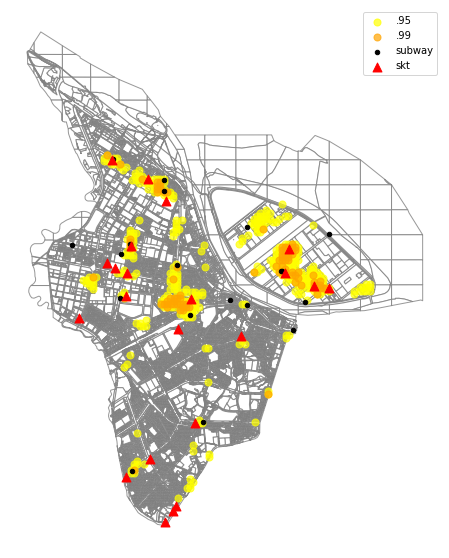

In [56]:
# SKT 대리점과 지하철, 유동인구
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
subway['geom'].plot(ax=base, marker='o', color='black', markersize=20, label='subway')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
base.set_axis_off()
base.legend()
plt.show()

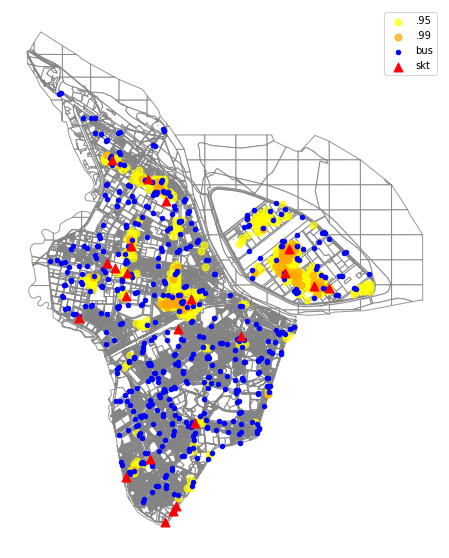

In [57]:
# SKT 대리점과 버스, 유동인구
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
# gpd.GeoSeries.from_wkt(grouped_bsn.index).plot(ax=base, marker='*', color='green', markersize=1, label='data')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
bus['geom'].plot(ax=base, marker='o', color='blue', markersize=20, label='bus')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
base.set_axis_off()
base.legend()
plt.show()

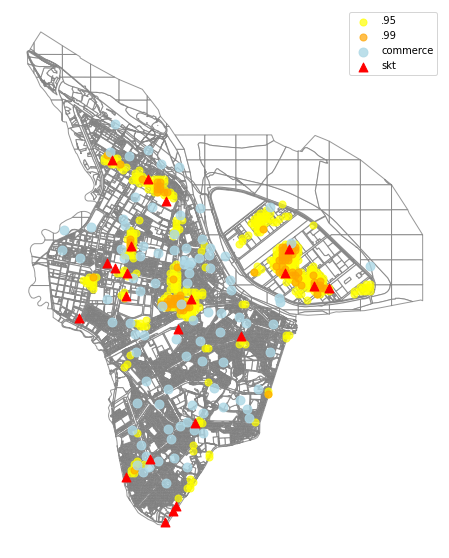

In [58]:
# SKT 대리점과 상권, 유동인구
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
comm_area['geom'].plot(ax=base, color='lightblue', marker='o', alpha=.8, markersize=80, label='commerce')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
base.set_axis_off()
base.legend()
plt.show()

In [59]:
# 동별 지역코드
code_list = {'영등포본동' : ['1156010100'],
             '영등포동' : ['1156010200', '1156010300', '1156010400', '1156010500', '1156010600', '1156010700', '1156010800', '1156010900'],
             '여의동' : ['1156011000'],
             '당산1동' : ['1156011100', '1156011200', '1156011300'],
             '당산2동' : ['1156011400', '1156011500', '1156011600', '1156011700'],
             '도림동' : ['1156011800'],
             '문래동' : ['1156011900', '1156012000', '1156012100', '1156012200', '1156012300', '1156012400'],
             '양평1동' : ['1156012500', '1156012600', '1156012700'],
             '양평2동' : ['1156012800', '1156012900', '1156013000', '1156013100', '1156013400'],
             '신길1동' : ['1156013200'],
             '신길3동' : ['1156013200'],
             '신길4동' : ['1156013200'],
             '신길5동' : ['1156013200'],
             '신길6동' : ['1156013200'],
             '신길7동' : ['1156013200'],
             '대림1동' : ['1156013300'],
             '대림2동' : ['1156013300'],
             '대림3동' : ['1156013300']}

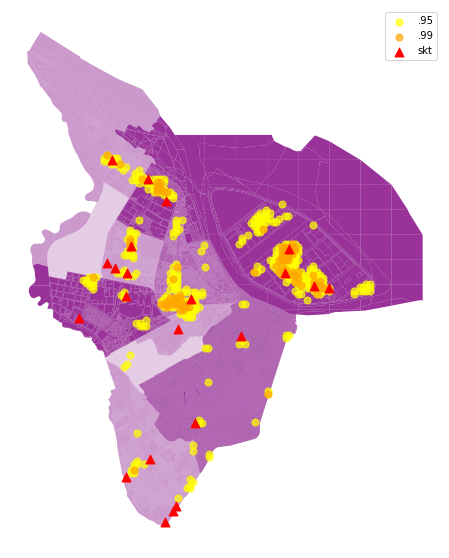

In [60]:
# SKT 대리점과 상주인구, 유동인구
base = gdf.plot(color='white', edgecolor='white', figsize=(10,10), alpha=0.8)
for dong in code_list.keys():
    gdf[gdf['pnu'].apply(lambda x : x[:10]).isin(code_list[dong])].plot(ax=base, color='Purple', alpha=(ingu['bin'][ingu['dong_name'] == dong].values[0] * 0.2), figsize=(10,10))
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
base.set_axis_off()
base.legend()
plt.show()

In [61]:
# 지리 데이터 비교를 위한 버퍼 컬럼 생성
skt['buff100'] = skt['geom'].buffer(0.001)
skt['buff300'] = skt['geom'].buffer(0.003)
skt['buff500'] = skt['geom'].buffer(0.005)
skt['buff1000'] = skt['geom'].buffer(0.01)

In [62]:
# 반경 약 300m 안의 버스 정류장 수
skt['bus'] = np.nan
for i in skt.index:
    a = bus[bus['geom'].within(skt['buff300'][i])]
    if a.count != 0:
        skt.at[i, 'bus'] = len(a)

In [63]:
# 대리점으로부터 가장 가까운 지하철 역의 좌표
sub_near = gpd.sjoin_nearest(gpd.GeoDataFrame(skt[['geom']], geometry='geom'), subway[['geom']]).sort_index()

In [64]:
# 가장 가까운 지하철 역과의 거리
skt['subway'] = np.nan
for i in skt.index:
    skt.at[i, 'subway'] = sub_near['geom'][i].distance(subway['geom'][sub_near['index_right'][i]])

In [65]:
# 반경 약 500m 안의 상권의 수, 매출액, 매출건수
skt['commerce'] = np.nan
skt['comm_sales'] = np.nan
skt['comm_count'] = np.nan
for i in skt.index:
    a = comm_area[comm_area['geom'].within(skt['buff500'][i])]
    skt.at[i, 'commerce'] = len(a)
    skt.at[i, 'comm_sales'] = a['분기당_매출_금액'].sum()
    skt.at[i, 'comm_count'] = a['분기당_매출_건수'].sum()

In [66]:
# 대리점으로부터 가장 가까운 상권의 좌표
comm_near = gpd.sjoin_nearest(gpd.GeoDataFrame(skt[['geom']], geometry='geom'), comm_area[['geom']]).sort_index()

In [67]:
# 가장 가까운 상권과의 거리
skt['comm_distance'] = np.nan
for i in skt.index:
    skt.at[i, 'comm_distance'] = comm_near['geom'][i].distance(comm_area['geom'][comm_near['index_right'][i]])

In [68]:
# 대리점 지역의 인구
skt['area_ingu'] = ingu.set_index('dong_name').loc[skt['dong_name']]['2019년09월_거주자 인구수'].values
skt['bin'] = ingu.set_index('dong_name').loc[skt['dong_name']]['bin'].values

In [69]:
bsn = grouped_bsn.reset_index()
bsn['geom'] = gpd.GeoSeries.from_wkt(bsn['geom'])
bsn = gpd.GeoDataFrame(bsn, geometry='geom')
bsn = bsn.set_crs(4326)

In [70]:
skt['ingu'] = np.nan
ingu_near = gpd.sjoin_nearest(skt[['geom']], bsn[['geom']]).sort_index()
# 대리점과 가장 가까운 지점의 비즈니스 시간대 유동인구
for i in skt.index:
    skt.at[i, 'ingu'] = bsn['all_ingu'][ingu_near['index_right'][i]]

In [71]:
skt['store'] = 0
# 근처 대리점의 수
for i in skt.index:
    skt.at[i, 'store'] = len(skt[skt['geom'].within(skt['buff1000'][i])])

In [72]:
# 100m, 300m, 500m, 1km 범위를 만듦
bsn['buff100'] = bsn['geom'].buffer(0.001)
bsn['buff300'] = bsn['geom'].buffer(0.003)
bsn['buff500'] = bsn['geom'].buffer(0.005)
bsn['buff1000'] = bsn['geom'].buffer(0.01)

In [73]:
# 유동인구 상위 .99, .95 수
skt['ingu_95'] = 0
skt['ingu_99'] = 0
for i in skt.index:
    if bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.95)]['buff100'].unary_union.contains(skt['geom'][i]):
        skt.at[i, 'ingu_95'] = 1
    if bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.99)]['buff100'].unary_union.contains(skt['geom'][i]):
        skt.at[i, 'ingu_99'] = 1

In [74]:
# 반경 약 300m 안의 버스 정류장 수
bsn['bus'] = np.nan
for i in bsn.index:
    a = bus[bus['geom'].within(bsn['buff300'][i])]
    if a.count != 0:
        bsn.at[i, 'bus'] = len(a)

In [75]:
# 가장 가까운 지하철 역의 좌표
sub_near = gpd.sjoin_nearest(bsn[['geom']], subway[['geom']]).sort_index()

In [76]:
# 가장 가까운 지하철 역과의 거리
bsn['subway'] = np.nan
for i in bsn.index:
    bsn.at[i, 'subway'] = sub_near['geom'][i].distance(subway['geom'][sub_near['index_right'][i]])

In [77]:
# 반경 약 500m 안의 상권의 수, 매출액, 매출건수
bsn['commerce'] = np.nan
bsn['comm_sales'] = np.nan
bsn['comm_count'] = np.nan
for i in bsn.index:
    a = comm_area[comm_area['geom'].within(bsn['buff500'][i])]
    bsn.at[i, 'commerce'] = len(a)
    bsn.at[i, 'comm_sales'] = a['분기당_매출_금액'].sum()
    bsn.at[i, 'comm_count'] = a['분기당_매출_건수'].sum()

In [78]:
# 대리점 지역의 인구
bsn['area_ingu'] = ingu.set_index('dong_name').loc[bsn['dong_name']]['2019년09월_거주자 인구수'].values
bsn['bin'] = ingu.set_index('dong_name').loc[bsn['dong_name']]['bin'].values

In [79]:
bsn['store'] = 0
# 근처 대리점의 수
for i in bsn.index:
    bsn.at[i, 'store'] = skt['geom'].within(bsn['buff1000'][4418]).value_counts()[True]

In [80]:
# 유동인구 상위 .99, .95 수
bsn['ingu_95'] = 0
bsn['ingu_99'] = 0
for i in bsn.index:
    if bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.95)]['buff100'].unary_union.contains(bsn['geom'][i]):
        bsn.at[i, 'ingu_95'] = 1
    if bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.99)]['buff100'].unary_union.contains(bsn['geom'][i]):
        bsn.at[i, 'ingu_99'] = 1

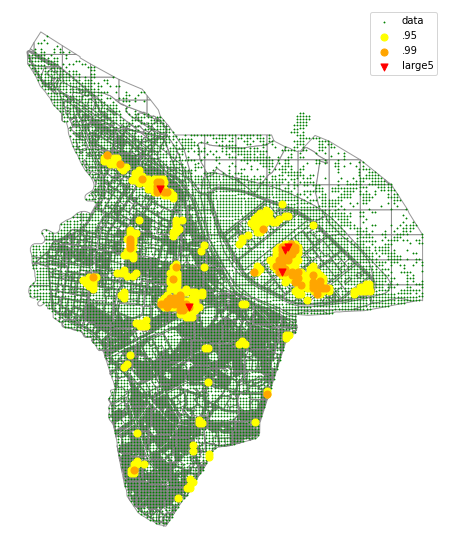

In [81]:
# 모든 유동인구 데이터 좌표와 상위 5개 지점
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
bsn['geom'].plot(ax=base, marker='*', color='green', markersize=1, label='data')
bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.95)]['geom'].plot(
    ax=base, marker='o', color='yellow', markersize=50, label='.95')
bsn[bsn['all_ingu'] >= bsn['all_ingu'].quantile(q=0.99)]['geom'].plot(
    ax=base, marker='o', color='orange', markersize=50, label='.99')
bsn.loc[bsn['all_ingu'].nlargest(5).index, 'geom'].plot(
    ax=base, marker='v', color='red', markersize=50, label='large5')
base.set_axis_off()
base.legend()
plt.show()

In [82]:
# 24시간 유동인구가 가장 많은 5개 동
df[df['geom'].astype('str').isin(grouped_all['all_ingu'].nlargest(5).index)]['dong_name'].unique()

['영등포본동', '영등포동', '여의동', '당산2동']
Categories (18, object): ['당산1동', '당산2동', '대림1동', '대림2동', ..., '양평2동', '여의동', '영등포동', '영등포본동']

In [83]:
# 비즈니스 타임에 유동인구가 가장 많은 5개 동
df[df['geom'].astype('str').isin(grouped_bsn['all_ingu'].nlargest(5).index)]['dong_name'].unique()

['영등포본동', '여의동', '당산2동']
Categories (18, object): ['당산1동', '당산2동', '대림1동', '대림2동', ..., '양평2동', '여의동', '영등포동', '영등포본동']

<영등포본동>


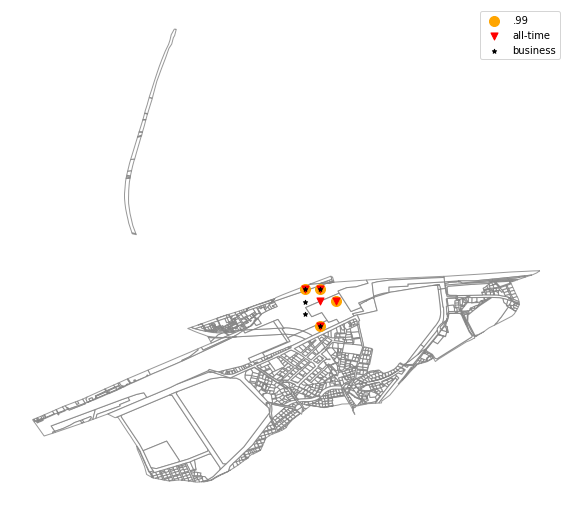

<영등포동>


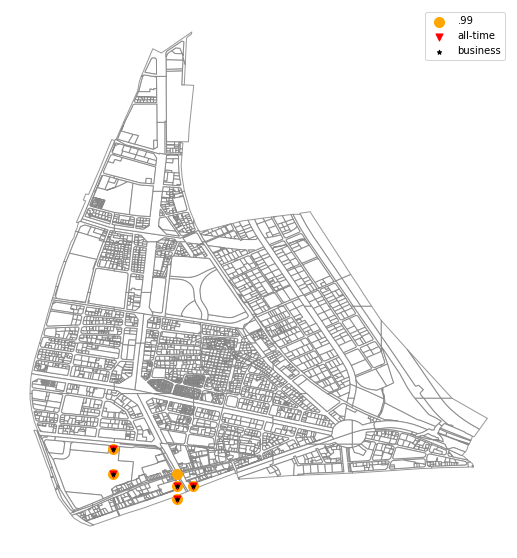

<여의동>


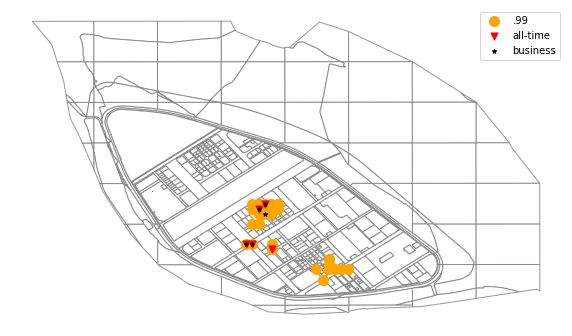

<당산1동>


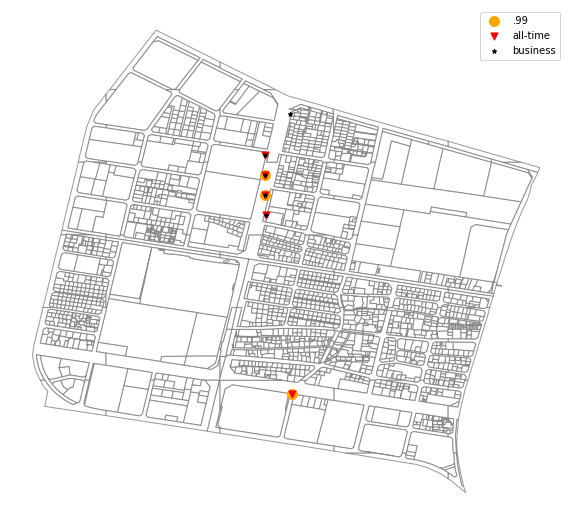

<당산2동>


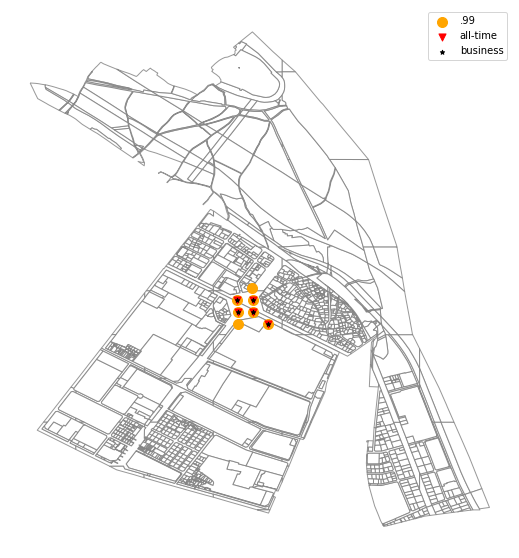

<도림동>


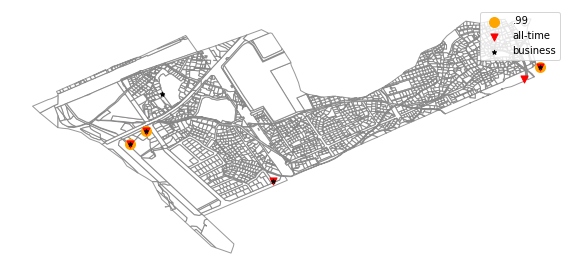

<문래동>


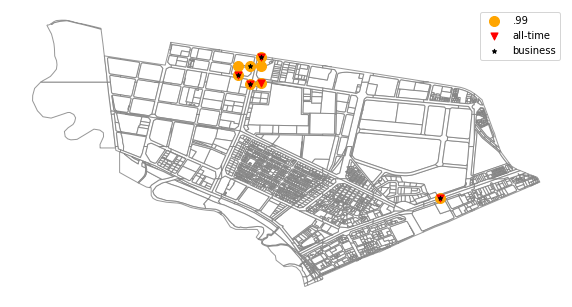

<양평1동>


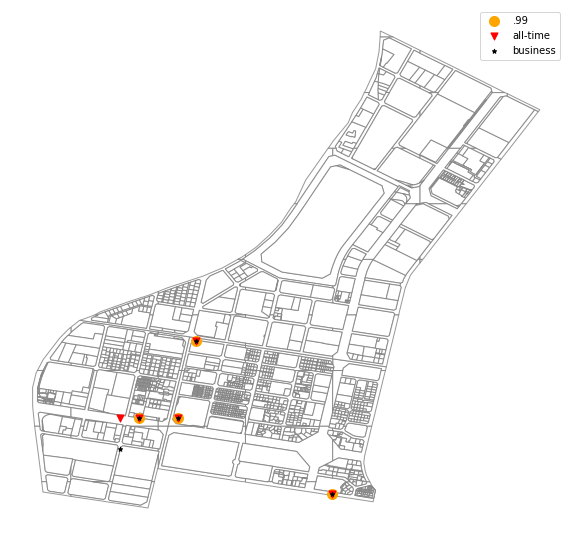

<양평2동>


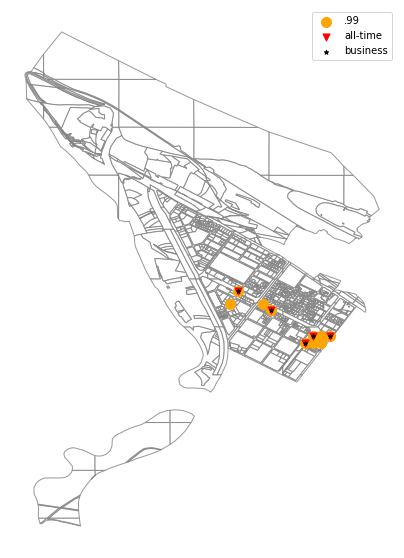

<신길1동>


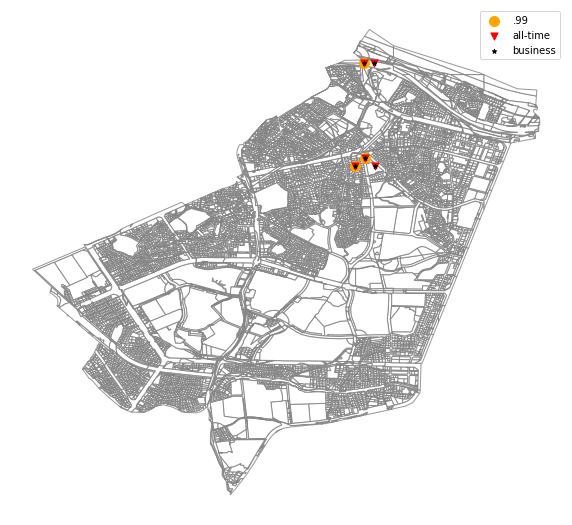

<신길3동>


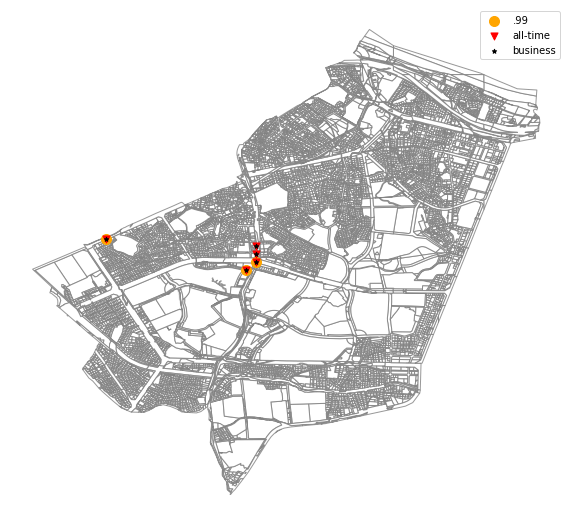

<신길4동>


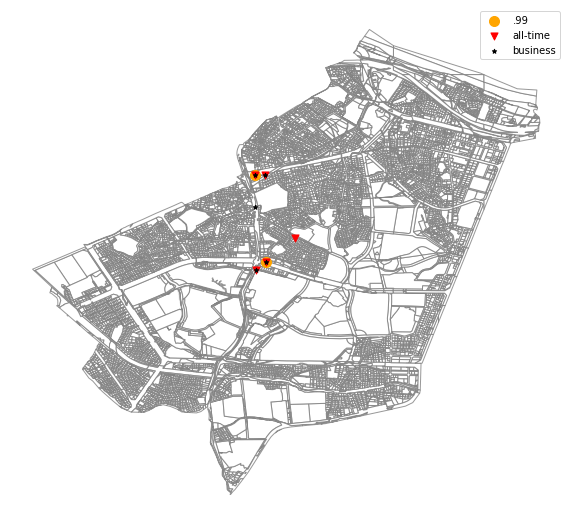

<신길5동>


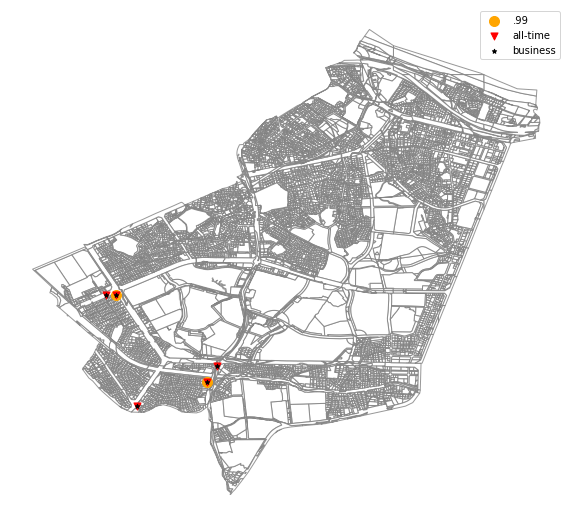

<신길6동>


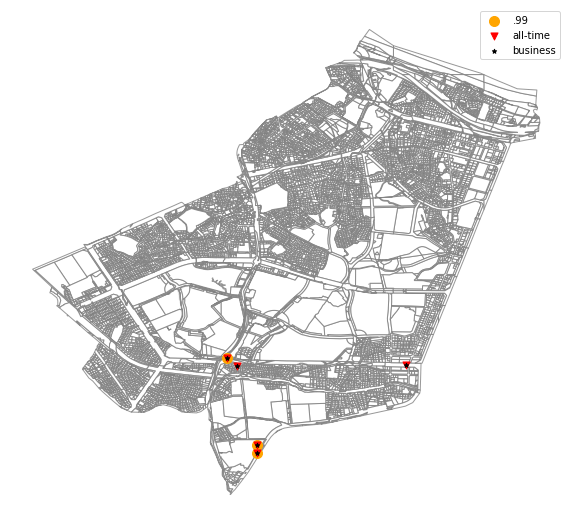

<신길7동>


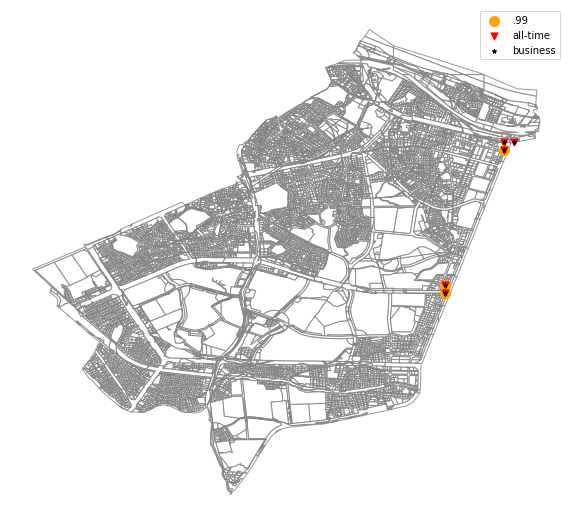

<대림1동>


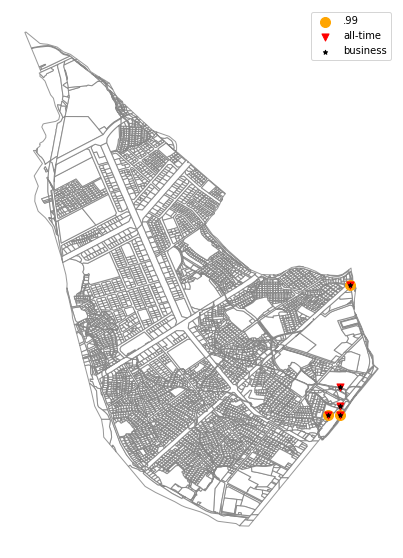

<대림2동>


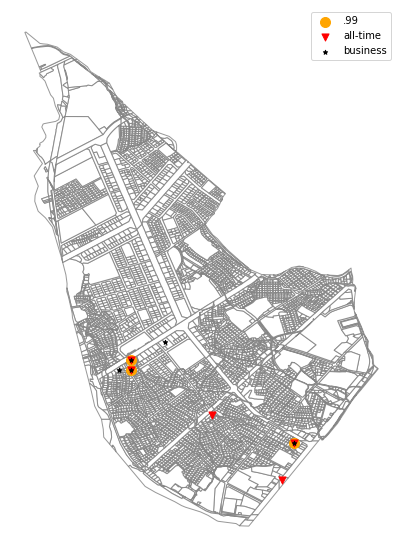

<대림3동>


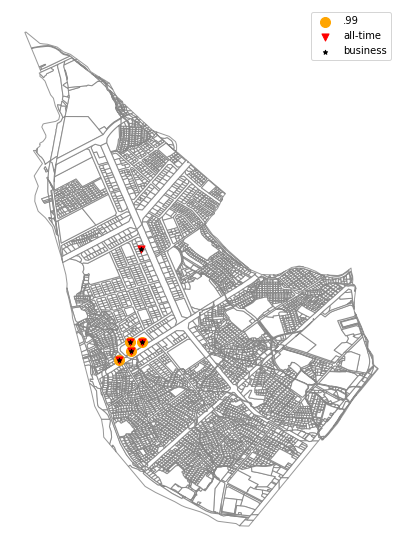

In [84]:
# 동별 인구 데이터 시각화
# 주황 - .99     역삼각형 - 24시간 유동인구 상위 5개지점    별 - 비즈니스 타임 유동인구 상위 5개지점
for dong in df['dong_name'].unique():
    # all
    temp_all = pd.DataFrame(df[df['dong_name'] == dong].groupby(by=df['geom'].astype('str'))['all_ingu'].agg(sum='sum'))
    # business
    temp_bsn = pd.DataFrame(df[df['dong_name'] == dong].loc[df['date'].dt.hour.between(9, 21)].groupby(by=df['geom'].astype('str'))['all_ingu'].agg(sum='sum'))
    print(f'<{dong}>')
    ax = gdf[gdf['pnu'].apply(lambda x : x[:10]).isin(code_list[dong])].plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
    gpd.GeoSeries.from_wkt(temp_all[temp_all['sum'] >= temp_all['sum'].quantile(q=0.99)].index.to_list()).plot(
        ax=ax, marker='o', color='orange', markersize=100, label='.99')
    gpd.GeoSeries.from_wkt(temp_all['sum'].nlargest(5).index.to_list()).plot(ax=ax, marker='v', color='red', markersize=50, label='all-time')
    gpd.GeoSeries.from_wkt(temp_bsn['sum'].nlargest(5).index.to_list()).plot(ax=ax, marker='*', color='k', markersize=20, label='business')
    ax.set_axis_off()
    plt.legend()
    plt.show()

# 5. 모델적용

In [85]:
# 이상치 처리
skt['commerce'][skt['commerce'] <= 0] = skt['commerce'].mean()
skt['comm_count'][skt['comm_count'] <= 0] = skt['comm_count'].mean()
bsn['commerce'][bsn['commerce'] <= 0] = bsn['commerce'].mean()
bsn['comm_count'][bsn['comm_count'] <= 0] = bsn['comm_count'].mean()

In [86]:
skt_df = skt[['geom', 'dong_name', 'bus', 'subway', 'commerce', 'comm_count', 'area_ingu', 'bin', 'ingu', 'ingu_95', 'ingu_99']].reset_index(drop=True)
bsn_df1 = bsn[['geom', 'dong_name', 'bus', 'subway', 'commerce', 'comm_count', 'area_ingu', 'bin', 'all_ingu', 'ingu_95', 'ingu_99']].rename(columns={'all_ingu':'ingu'}).reset_index(drop=True)

In [87]:
skt_df.head(5)

geom dong_name   bus    subway  commerce  \
0  POINT (126.93277 37.51937)       여의동  11.0  0.004824  3.636364   
1  POINT (126.92554 37.52504)       여의동  12.0  0.003498  1.000000   
2  POINT (126.89996 37.53510)      당산2동  12.0  0.002816  5.000000   
3  POINT (126.89392 37.52229)      당산1동  10.0  0.002207  5.000000   
4  POINT (126.88730 37.51496)       문래동   7.0  0.008026  3.636364   

     comm_count  area_ingu  bin         ingu  ingu_95  ingu_99  
0  2.310650e+06      33229  4.0  2169.628538        1        1  
1  6.837998e+06      33229  4.0  4773.451129        1        1  
2  4.811451e+06      35208  4.0  2073.522450        1        0  
3  2.432379e+06      20611  2.0   729.752280        1        0  
4  2.310650e+06      31273  4.0   577.983174        0        0

In [88]:
bsn_df = bsn_df1.copy()

In [89]:
skt_ddf = skt_df.copy()

In [90]:
# 유동인구 .95에 해당되지 않는 지역 제외
bsn_df = bsn_df[bsn_df['ingu_95'] >= 1].reset_index(drop=True)

In [91]:
# 스케일링
scaler = MinMaxScaler()
skt_scaled = scaler.fit_transform(skt_df.iloc[:, 2:].copy())
bsn_scaled = scaler.fit_transform(bsn_df.iloc[:, 2:].copy())

###K-Means 클러스터###

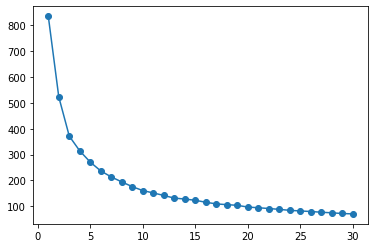

In [92]:
# 스케일 후 k-means
distortions = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=int(k), n_init=10, random_state=1234)
    y_pred = kmeans.fit(bsn_scaled.copy())
    distortions.append(kmeans.inertia_)
    del y_pred, kmeans

plt.plot(range(1, 31), distortions, marker='o')
plt.show()

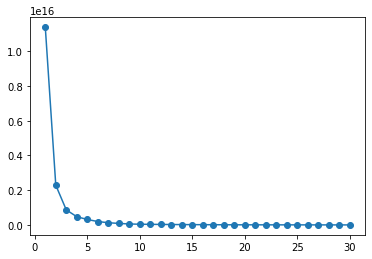

In [93]:
# 스케일 전 k-means
distortions = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=int(k), n_init=10, random_state=1234)
    y_pred = kmeans.fit(bsn_df.iloc[:, 2:].copy())
    distortions.append(kmeans.inertia_)
    del y_pred, kmeans

plt.plot(range(1, 31), distortions, marker='o')
plt.show()

In [94]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=1234)
y_pred = kmeans.fit(bsn_df.iloc[:, 2:].copy())
y_test = kmeans.predict(skt_df.iloc[:, 2:].copy())

In [95]:
aa = bsn_df.copy()
aa['kmeans'] = kmeans.predict(bsn_df.iloc[:, 2:].copy())
aa

geom dong_name   bus    subway  commerce  \
0     POINT (126.88759 37.52097)       문래동  12.0  0.004824       1.0   
1     POINT (126.88760 37.52052)       문래동  13.0  0.005257       1.0   
2     POINT (126.88760 37.52007)       문래동  12.0  0.005691       1.0   
3     POINT (126.88815 37.52143)      양평1동  10.0  0.004612       1.0   
4     POINT (126.88816 37.52097)       문래동  10.0  0.005022       1.0   
...                          ...       ...   ...       ...       ...   
1379  POINT (126.94078 37.52033)       여의동   1.0  0.010386       1.0   
1380  POINT (126.94079 37.51988)       여의동   1.0  0.010688       1.0   
1381  POINT (126.94079 37.51943)       여의동   1.0  0.010999       1.0   
1382  POINT (126.94079 37.51898)       여의동   1.0  0.011320       1.0   
1383  POINT (126.94080 37.51853)       여의동   1.0  0.011650       1.0   

      comm_count  area_ingu  bin        ingu  ingu_95  ingu_99  kmeans  
0       102604.0      31273  4.0  436.048178        1        0       0  
1       102604.0      31273  4.0  377.628222        1        0       0  
2       102604.0      31273  4.0  707.581557        1        0       0  
3       102604.0      17658  1.0  364.275538        1        0       0  
4       102604.0      31273  4.0  328.915843        1        0       0  
...          ...        ...  ...         ...      ...      ...     ...  
1379    249276.0      33229  4.0  535.877253        1        0       0  
1380    249276.0      33229  4.0  655.944229        1        0       0  
1381    249276.0      33229  4.0  785.686984        1        0       0  
1382    249276.0      33229  4.0  468.455252        1        0       0  
1383    249276.0      33229  4.0  270.630684        1        0       0  

[1384 rows x 12 columns]

###DBSCAN - K-means###

In [96]:
np.unique(kmeans.predict(skt_df.iloc[:, 2:]))

array([0, 1, 2], dtype=int32)

In [97]:
for s in range(10, 21):
    for e in np.arange(80, 91, 2):
    ##### 입실론이 커도 되는가에 의문...
    ##### 작은 입실론에서는 분류가 발생하지 않는다.
    # for e in np.arange(0.01, 1.0, 0.02):
        model = DBSCAN(eps=e, min_samples=s)
        predict = pd.DataFrame(model.fit_predict(bsn_df.iloc[:, 2:]))
        predict.columns=['predict']
        result = pd.concat([bsn_df, predict], axis=1)
        kmeans = KMeans(n_clusters=np.unique(result.predict).shape[0], n_init=10, random_state=1234)
        kmeans.fit(bsn_df.iloc[:, 2:].copy())
        print(s, e, kmeans.predict(skt_df.iloc[:, 2:]), len(np.unique(kmeans.predict(skt_df.iloc[:, 2:]))), result.predict.value_counts().values[0])

10 80 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1251
10 82 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1246
10 84 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1245
10 86 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1242
10 88 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1237
10 90 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1232
11 80 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1258
11 82 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1255
11 84 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1252
11 86 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1248
11 88 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1248
11 90 [4 1 8 4 4 4 0 2 5 4 4 5 0 3 1 8 4 4 5 0 0 5] 7 1246
12 80 [2 1 2 2 2 2 0 2 0 2 2 0 0 3 1 2 2 2 0 0 0 0] 4 1332
12 82 [4 1 2 2 4 2 4 2 0 2 4 0 0 3 1 2 4 4 0 4 0 0] 5 1320
12 84 [2 1 5 2 2 2 4 2 0 2 2 0 0 3 1 5 2 2 0 4 0 0] 6 1305
12 86 [5 4 0 5 5 5 3 5 1 5 5 1 1 2 4 0 5 5 1 3 1 1] 6 1291
12 88 [5 4 0 5 5 5 3 5 1 5 5 1 1 2 4 0 5 5 1 3 1 1] 6 12

In [ ]:
# model = DBSCAN(eps=80, min_samples=13)
# model = DBSCAN(eps=96, min_samples=13)

In [103]:
model = DBSCAN(eps=80, min_samples=14)
predict = pd.DataFrame(model.fit_predict(bsn_df.iloc[:, 2:]))
predict.columns=['predict']
result = pd.concat([bsn_df, predict], axis=1)

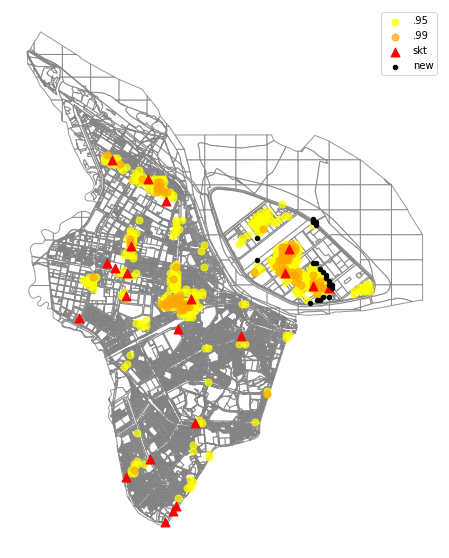

In [104]:
# 결과값 표출
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
result[(result.predict == 0) | (result.predict == 1)]['geom'].plot(ax=base, marker='o', color='black', markersize=20, label='new')
base.set_axis_off()
base.legend()
plt.show()

###Random Forest###

In [107]:
# 대리점 반경 100미터 내의 지점들
temp = []
for i in skt_df.index:
    temp.append(bsn_df[bsn_df['geom'].within(skt['buff100'][i])])
store_df = pd.concat(temp, axis=0)
store_df.drop_duplicates(['geom'], inplace=True)

In [108]:
# 대리점 데이터와 병합 후, 1로 카테고리 설정
store_df = pd.concat([skt_df, store_df], axis=0, ignore_index=True).reset_index(drop=True)
store_df['target'] = 1

In [109]:
# 유동인구가 적은 곳 중, 무작위 추출 후 0으로 카테고리 설정
none_df = bsn_df1[bsn_df1['ingu_95'] <= 0].sample(len(store_df))
none_df['target'] = 0

In [110]:
# 학습 데이터
train_df = pd.concat([store_df, none_df], axis=0).reset_index(drop=True)

In [111]:
# 테스트 데이터
test_df = bsn.loc[~bsn.index.isin(none_df.index)].sample(len(train_df)).reset_index(drop=True).rename(columns={'all_ingu':'ingu'})

In [112]:
test_df = test_df[list(train_df)[:-1]]

In [113]:
print(train_df.info(), test_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geom        346 non-null    geometry
 1   dong_name   346 non-null    object  
 2   bus         346 non-null    float64 
 3   subway      346 non-null    float64 
 4   commerce    346 non-null    float64 
 5   comm_count  346 non-null    float64 
 6   area_ingu   346 non-null    int64   
 7   bin         346 non-null    float64 
 8   ingu        346 non-null    float64 
 9   ingu_95     346 non-null    int64   
 10  ingu_99     346 non-null    int64   
 11  target      346 non-null    int64   
dtypes: float64(6), geometry(1), int64(4), object(1)
memory usage: 32.6+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geom        346 non-n

In [130]:
# 데이터 분리
# train_len = int(len(train_df) * 0.8)
# train_X = train_df.iloc[:train_len, 2:-1]
# train_y = train_df.iloc[:train_len, -1]
# val_X = train_df.iloc[train_len:, 2:-1]
# val_y = train_df.iloc[train_len:, -1]
train_X, val_X, train_y, val_y = train_test_split(train_df.iloc[:, 2:-1], train_df.iloc[:, -1], test_size=0.2, shuffle=True, stratify=train_df.iloc[:, -1], random_state=34)

In [131]:
rf_clf = RandomForestClassifier(random_state=1234)
rf_clf.fit(train_X, train_y)
pred = rf_clf.predict(val_X)
accuracy = accuracy_score(val_y.values, pred)
print(accuracy)
# 검증 데이터 수가 워낙 작아서 1.0이 가능한 것으로 보임(70개)

1.0


In [116]:
pred2 = rf_clf.predict(test_df.iloc[:, 2:])

In [117]:
test_df['target'] = pred2

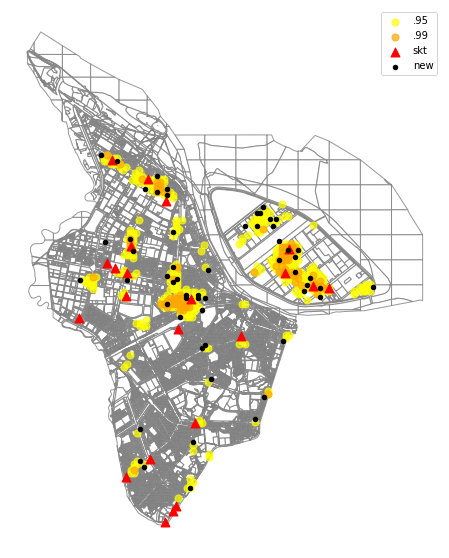

In [118]:
# 결과값 표출
base = gdf.plot(color='white', edgecolor='grey', figsize=(10,10), alpha=0.8)
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.95)].index.to_list()).plot(
    ax=base, marker='o', color='yellow', alpha=.7, markersize=50, label='.95')
gpd.GeoSeries.from_wkt(grouped_bsn[grouped_bsn['all_ingu'] >= grouped_bsn['all_ingu'].quantile(q=0.99)].index.to_list()).plot(
    ax=base, marker='o', color='orange', alpha=.7, markersize=50, label='.99')
skt['geom'].plot(ax=base, marker='^', color='red', markersize=80, label='skt')
test_df[test_df['target'] == 1]['geom'].plot(ax=base, marker='o', color='black', markersize=20, label='new')
base.set_axis_off()
base.legend()
plt.show()

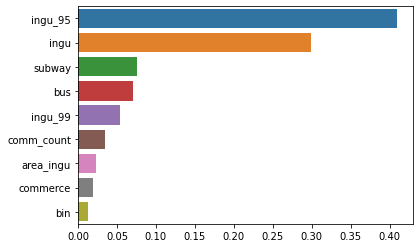

In [119]:
ftr_imp_values = rf_clf.feature_importances_
ftr_imp = pd.Series(ftr_imp_values, index=train_X.columns)
ftr_top = ftr_imp.sort_values(ascending=False)
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

# 결론

- KNN, K-Means, DBSCAN에서는 좋은 결과를 내지 못했다.

- Random Forest에서 테스트 데이터에서 좋은 입지를 선정할 수 있었다.